In [4]:
import observational_fear.load as load
from observational_fear.nbox_transforms import (
    summarize_prepost_events,
    wilcoxon_by_cell,
)
from observational_fear.events import get_block_starts
from observational_fear.stats import auc
from neurobox.wide_transforms import resample
from pathlib import Path
import pandas as pd
import numpy as np
from binit.align import align_around
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from observational_fear.events import get_freeze_starts
from neurobox.long_transforms import align_to_events
from observational_fear.nbox_transforms import align_to_data_by, exclude_short_trials
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.base import clone
from scipy.spatial import distance_matrix
from scipy.spatial.distance import euclidean
from scipy.ndimage import gaussian_filter1d
sns.set_style("whitegrid")

DATA_DIR = Path(r"E:\OFL\one-p experiment\data")
FIG_DIR = Path(r"C:\Users\roryl\repos\observational-fear\figs")


In [3]:
def get_bloc_psth(df, cs_starts, gaussian=None):
    df = df.reset_index().melt(id_vars=["time"])
    res = (
        df
        .assign(
            aligned=lambda x: np.round(
                align_around(x["time"].values, cs_starts, t_before=5, max_latency=5), 2
            )
        )
        .pivot_table(columns="new_id", values="value", index="aligned")
        .apply(zscore)
    )
    if gaussian:
        res = res.apply(gaussian_filter1d, sigma=gaussian)
    return res


def shuffle_block(df_traces, block_starts, pipe, n_reps=10):
    shuffled_scores = []
    for _ in range(n_reps):
        df_shuffled = df_traces.sample(frac=1).copy()
        df_shuffled.index = df_traces.index

        df_shuffled = get_bloc_psth(df_shuffled, block_starts)
        X = df_shuffled.dropna()
        y = np.where(df_shuffled.index <= 0, "ITI", "CS")
        pipe1 = clone(pipe)

        scores=cross_val_score(pipe1, X=X, y=y, scoring="f1_macro")
        shuffled_scores.append(scores)
    return shuffled_scores

def plot_pcs(X, y, **kwargs):
    to_plot = pd.DataFrame(PCA(2).fit_transform(X)[:, :2], columns=["PC1", "PC2"]).assign(color=X.index)
    to_plot["y"] = y
    return sns.lineplot(x="PC1", y="PC2", hue="y", data=to_plot, ci=None, **kwargs)
    

def get_pcs(X, y, num_components=2):
    pcs = pd.DataFrame(PCA(2).fit_transform(X)[:, :2], columns=["PC1", "PC2"]).assign(time=X.index)
    pcs["state"] = y
    return pcs

def get_pcs_dist(X, y, blocks, num_components=2):
    pcs = get_pcs(X, y, num_components=num_components)
    for block in blocks:
        centroid = pcs.loc[lambda x: x.state == block][["PC1", "PC2"]].mean().values
        pcs[f"distance to {block} centroid"] = pcs[["PC1", "PC2"]].apply(lambda x: euclidean(x, centroid), axis=1).values
    return pcs

# Day 2 CS

In [3]:
SESSION = "day2"
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

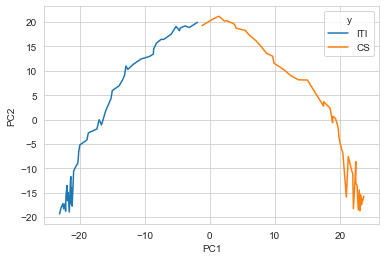

In [22]:
SESSION = "day2"
df = load.load_traces(DATA_DIR, session=SESSION)
BLOCK = "CS"
BLOCKS = ("ITI", "CS")

df = resample(df.set_index("time"), "100ms")
df_real = df
events = get_block_starts(session=SESSION, block_name=BLOCK)
block_names = BLOCKS
X = get_bloc_psth(df_real, events)

y = np.where(X.index <= 0, *BLOCKS)
pipe = make_pipeline(
    # PCA(2), 
    LogisticRegression()
    )
obs_f1scores = cross_val_score(clone(pipe), X, y, scoring="f1_macro")

# reps = shuffle_block(df, events, pipe)

plot_pcs(X, y)

In [5]:
results = {}
results["F1 scores (Cross Validation Replicates)"] = obs_f1scores
results["Mean Shuffled F1 (500 shuffles)"] = np.mean(reps)
results["P Value (Proportion shuffled f1 scores as large as mean observed f1 score)"] = np.mean(reps >= obs_f1scores.mean())
# pd.Series(results).to_csv(f"{BLOCK} {SESSION} Decoder.csv")
# get_pcs_dist(X, y, blocks=BLOCKS).to_csv(f"{BLOCK} {SESSION} PCs.csv")

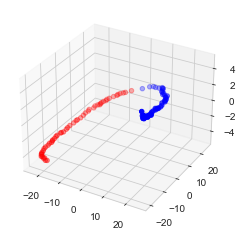

In [27]:
pcs = pd.read_csv("cs day2 PCs.csv")
# pcs = get_pcs_dist(X, y, blocks=BLOCKS)
pcs["color"] = np.where(pcs.state == "CS", "b", "r")

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pcs.PC1, pcs.PC2, pcs.time, c=pcs["color"].values)

<AxesSubplot:xlabel='time'>

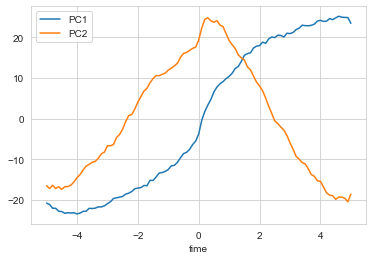

In [28]:
ax = pcs.plot(x="time", y="PC1")
pcs.plot(x="time", y="PC2", ax=ax)

In [34]:
pcs

,Unnamed: 0,PC1,PC2,time,state,distance to ITI centroid,distance to US centroid,color
0,0,-24.753359,-2.260862,-5.0,ITI,2.102185,48.756782,r
1,1,-24.897998,-2.396502,-4.9,ITI,2.298489,48.909359,r
2,2,-24.719776,-2.226919,-4.8,ITI,2.054735,48.721259,r
3,3,-24.599204,-2.032608,-4.7,ITI,1.827651,48.589882,r
4,4,-24.754730,-1.876259,-4.6,ITI,1.817302,48.736903,r
...,...,...,...,...,...,...,...,...
96,96,18.693304,-31.164087,4.6,US,52.051759,32.215110,b
97,97,17.902158,-31.653621,4.7,US,51.705726,32.833961,b
98,98,17.159736,-31.983995,4.8,US,51.315230,33.301497,b
99,99,16.264099,-32.012321,4.9,US,50.626987,33.522318,b


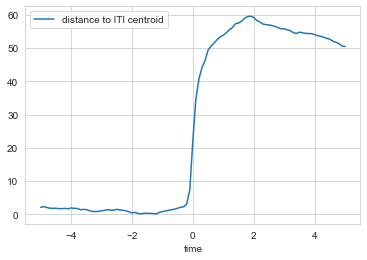

In [35]:
ax = pcs.plot(x="time", y="distance to ITI centroid")

In [94]:
SESSION = "day2"
df = load.load_traces(DATA_DIR, session=SESSION)
BLOCK = "CS"
BLOCKS = ("ITI", "CS")

df = resample(df.set_index("time"), "100ms")
df_real = df
events = get_block_starts(session=SESSION, block_name=BLOCK)[:5]
block_names = BLOCKS
X = get_bloc_psth(df_real, events)

y = np.where(X.index <= 0, *BLOCKS)
pipe = make_pipeline(
    # PCA(2), 
    LogisticRegression()
    )
# obs_f1scores = cross_val_score(clone(pipe), X, y, scoring="f1_macro")

# reps = shuffle_block(df, events, pipe)


c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


<AxesSubplot:xlabel='time'>

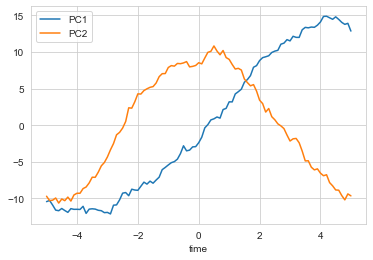

In [107]:
pcs = get_pcs_dist(X.sample(frac=0.3, axis=1), y, blocks=BLOCKS)

ax = pcs.plot(x="time", y="PC1")
pcs.plot(x="time", y="PC2", ax=ax)

In [84]:
X2 = X.loc[lambda x: x.index < 0].sample(frac=1)
X3 = X.loc[lambda x: x.index >= 0]

X4 = pd.concat([X2, X3])
X4.index = X.index

<AxesSubplot:xlabel='time'>

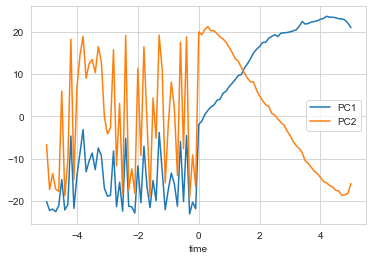

In [85]:
pcs = get_pcs_dist(X4, y, blocks=BLOCKS)

ax = pcs.plot(x="time", y="PC1")
pcs.plot(x="time", y="PC2", ax=ax)



In [93]:
num_cols = X.shape[1]
frac = 0.5

X.sample(axis=1, frac=0.5)

new_id,1083,885,761,1748,989,1491,1565,866,1901,953,...,1389,1092,826,1569,399,1547,229,884,224,1559
aligned,,,,,,,,,,,,,,,,,,,,,
-5.0,-0.750215,-0.565972,0.270777,-0.010669,-0.438345,1.803732,1.324929,0.956276,-0.968810,-0.666869,...,-0.938754,-0.863866,2.377201,2.520659,-1.487557,-0.037590,-1.161299,0.157934,-1.171813,0.459804
-4.9,-0.591032,-0.443541,0.038321,-0.543308,-0.223458,1.468406,1.467173,0.951032,-1.139981,-0.319231,...,-0.987251,-1.116084,2.726480,1.862356,-1.411728,0.607879,-0.832930,0.048110,-1.386179,0.233117
-4.8,-1.904572,-0.331813,-0.131196,-0.256368,1.177733,1.490114,0.889991,0.970104,0.150051,-0.180151,...,-1.033139,-0.951523,2.015613,1.798986,-1.252399,0.135926,-0.490100,-0.062801,-1.574489,0.072473
-4.7,-0.735761,-0.179117,0.008800,-0.071693,1.720708,1.610698,0.886206,0.922003,-0.543200,0.330954,...,-1.035096,-0.821952,2.092351,1.850535,-1.436552,0.694571,-0.710605,-0.309454,-1.715686,-0.176268
-4.6,-1.448794,-0.021376,0.015773,0.771010,0.787919,1.586896,0.971410,0.920166,0.573257,0.345212,...,-1.078410,-1.174926,2.236957,1.267361,-1.390589,-0.535853,-0.483698,-0.234881,-0.888249,-0.424277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.6,0.416380,-1.040022,-0.099233,0.873604,-0.283927,-1.381570,0.919225,-1.555035,2.161613,-1.296686,...,2.079954,-0.968784,-0.405682,-1.033084,-1.226809,1.189730,0.176053,-0.896257,-1.390033,0.470552
4.7,0.616476,-0.946439,-0.211345,0.811356,-0.527037,-1.033741,0.707907,-1.522023,2.143256,-1.839179,...,2.206829,-0.492842,-0.876882,-1.038671,-0.981383,1.224511,0.000806,-0.968086,-1.710827,0.232081
4.8,-0.697201,-1.129650,-0.481785,0.779059,-0.822758,-0.995561,-0.003987,-1.483957,1.491150,-1.265867,...,1.989149,-0.563627,0.136942,-1.295801,-0.711070,2.875472,0.017529,-0.944045,0.238419,0.602721


In [90]:
np.random.choice(num_cols, int(num_cols * frac), replace=False)

array([ 973,  765,  141,  192,  278,  956,  821,  177,  785,  129,  172,
        594, 1046,  740,  292,  747,  940,    8, 1030,  829,  989,  808,
        686,  237,   52,  196,   38,  927,  581,  293,  369,  212,   78,
        201,  607,  171,  755,  825,   10,  935,  408,  231,  637,  304,
        335,  583, 1012,   57,  353,  187,  610,  944,  261,  296,    0,
        198,  320, 1036,  924,  107,  512,  754,  176,  466, 1001,  857,
        986,  868,  660,  869,  957,  967,  793,  613, 1061,  265,  953,
        322,  489,  435,  361,  978,  392, 1084,  455,  851,  775,  336,
         40,  493,  718,  209,  136,  509,   64,  901,  992,  279,  522,
        539, 1056,  262,  223,  491,  897, 1002,  976, 1076, 1022,  871,
        204,  220,  733,  920,  596,  914,  112,  609,  744,  132,  109,
        101,  657,  494,  776,  443,   53,  761,  665,  806,  601,   77,
        277,  406,   27,  707,  415,  898,   80,  750,  492,  411,  174,
         21,  917,  528,   97,  216,  170,  667,  7

In [79]:
X2

new_id,0,1,10,1000,1003,1004,1005,1006,1008,1009,...,974,977,979,984,986,988,989,994,997,999
aligned,,,,,,,,,,,,,,,,,,,,,
-5.0,0.576929,1.313244,-0.257735,3.153927,1.610160,1.424002,0.417579,2.572971,-0.521487,-1.594608,...,0.883266,-0.687490,-1.895877,-0.871161,-0.837352,-1.171347,-0.438345,1.827696,-2.168026,2.461721
-4.9,0.177693,1.056091,-0.192317,2.869810,1.640853,0.867034,0.486389,1.918764,-0.713435,-1.546877,...,1.008578,-1.691003,-1.767100,0.781959,-1.093307,-0.136183,-0.223458,1.929615,-0.735886,2.106625
-4.8,0.368233,0.813704,-0.270353,2.487620,1.757136,0.777424,0.154040,1.740396,-1.414287,-1.641119,...,0.909194,-1.851985,-1.596377,-0.229926,-0.984709,-1.624903,1.177733,2.355563,-0.326017,1.509954
-4.7,0.935938,0.585235,-0.135601,2.498898,1.410014,0.663740,0.726777,1.657859,-1.816222,-1.569425,...,0.776561,-1.288167,-1.381946,0.509458,-1.134775,-0.183354,1.720708,2.343695,-0.403914,1.429674
-4.6,0.874166,0.736028,-0.260035,2.390987,1.071424,1.015180,1.486891,1.484761,-0.934876,-1.529440,...,1.334973,0.470190,-1.593068,0.018728,-1.127397,0.023508,0.787919,2.306990,-0.750646,0.933030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.6,-1.130648,-0.005912,1.565305,0.540760,-1.021204,-0.309498,-1.637466,1.452036,-0.973227,-0.045041,...,-1.042590,0.735725,1.329329,-2.435879,1.657376,-1.061877,-0.283927,0.324842,-0.675066,0.199763
4.7,-1.319700,0.349572,1.459002,1.065427,-1.176376,0.692913,-1.522613,2.104797,-1.278681,-0.139698,...,-0.072229,-1.245350,1.050649,-2.004616,1.790398,-1.343985,-0.527037,-0.457849,0.082546,-0.122959
4.8,-1.439232,0.641947,1.687862,1.647953,-1.180018,1.704472,-1.654052,2.404720,-0.997958,-0.051419,...,-0.009716,-0.516080,0.904891,-1.545505,1.800864,-0.229265,-0.822758,-0.369943,-0.246500,0.182601


# Day 2 US

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

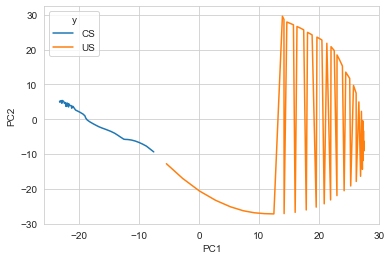

In [6]:

SESSION = "day2"
df = load.load_traces(DATA_DIR, session=SESSION)
BLOCK = "US"
BLOCKS = ("CS", "US")

df = resample(df.set_index("time"), "100ms")
df_real = df
events = get_block_starts(session=SESSION, block_name=BLOCK)
block_names = BLOCKS
X = get_bloc_psth(df_real, events, gaussian=1)

y = np.where(X.index <= 0, *BLOCKS)
pipe = make_pipeline(
    # PCA(2), 
    LogisticRegression()
    )
obs_f1scores = cross_val_score(clone(pipe), X, y, scoring="f1_macro")

reps = shuffle_block(df, events, pipe)

plot_pcs(X, y)

In [7]:
results = {}
results["F1 scores (Cross Validation Replicates)"] = obs_f1scores
results["Mean Shuffled F1 (500 shuffles)"] = np.mean(reps)
results["P Value (Proportion shuffled f1 scores as large as mean observed f1 score)"] = np.mean(reps >= obs_f1scores.mean())
pd.Series(results).to_csv(f"{BLOCK} {SESSION} Decoder.csv")
get_pcs_dist(X, y, blocks=BLOCKS).to_csv(f"{BLOCK} {SESSION} PCs.csv")

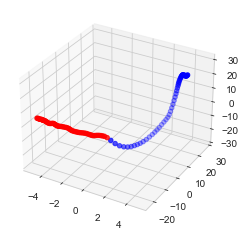

In [29]:
pcs = pd.read_csv("us day2 PCs.csv")
pcs["color"] = np.where(pcs.state == "US", "b", "r")

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pcs.time, pcs.PC1, pcs.PC2, c=pcs["color"].values)

<AxesSubplot:xlabel='time'>

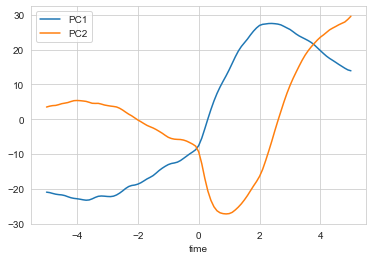

In [30]:
ax = pcs.plot(x="time", y="PC1")
pcs.plot(x="time", y="PC2", ax=ax)

In [1]:

SESSION = "day4"
BLOCK = "US"
BLOCKS = ("ITI", "US")

df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")
df_real = df

events = get_block_starts(session=SESSION, block_name=BLOCK)
block_names = BLOCKS
X = get_bloc_psth(df_real, events)

y = np.where(X.index <= 0, *BLOCKS)
pipe = make_pipeline(
    # PCA(2), 
    LogisticRegression()
    )
obs_f1scores = cross_val_score(clone(pipe), X, y, scoring="f1_macro")

reps = shuffle_block(df, events, pipe)

plot_pcs(X, y)

NameError: name 'load' is not defined

In [11]:
results = {}
results["F1 scores (Cross Validation Replicates)"] = obs_f1scores
results["Mean Shuffled F1 (500 shuffles)"] = np.mean(reps)
results["P Value (Proportion shuffled f1 scores as large as mean observed f1 score)"] = np.mean(reps >= obs_f1scores.mean())
pd.Series(results).to_csv(f"{BLOCK} {SESSION} Decoder.csv")
get_pcs_dist(X, y, blocks=BLOCKS).to_csv(f"{BLOCK} {SESSION} PCs.csv")

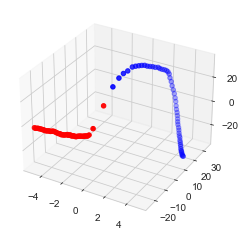

In [31]:
pcs = pd.read_csv("us day4 PCs.csv")
pcs["color"] = np.where(pcs.state == "US", "b", "r")

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pcs.time, pcs.PC1, pcs.PC2, c=pcs["color"].values)

<AxesSubplot:xlabel='time'>

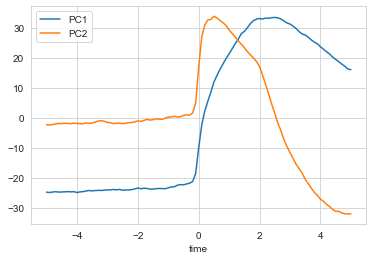

In [32]:
ax = pcs.plot(x="time", y="PC1")
pcs.plot(x="time", y="PC2", ax=ax)

In [165]:
# Day 4 CS
session = "day4"
df = load.load_traces(DATA_DIR, session=SESSION)
df = resample(df.set_index("time"), "100ms")
df = df.reset_index().melt(id_vars=["time"])

results_day2_freeze_starts = pd.read_csv(DATA_DIR / "freeze_starts_day2.csv")
df_freeze = load.load_freeze(DATA_DIR, SESSION)

events_day2_freeze_starts = get_freeze_starts(
    df_freeze, freeze_col="was_freezing_dem", mouse_col="mouse_name"
)

df_events = events_day2_freeze_starts.rename(columns={"mouse_name": "mouse"})

traces_day2_freeze_starts = align_to_data_by(
    df_data=load.load_cells(DATA_DIR).assign(new_id=lambda x: x.new_id.astype(str)).merge(df).copy(),
    df_events=df_events,
    df_data_time_col="time",
    df_data_cell_col="new_id",
    df_data_value_col="value",
    time_before_event=5,
    time_after_event=2,
    df_data_group_col="mouse",
    df_events_timestamp_col="freeze_start",
    df_events_group_colname="mouse",
    precision=2,
)
traces_day2_freeze_starts = exclude_short_trials(traces_day2_freeze_starts,
                trial_col="event",
                min_bins_pre_event=30,
                min_bins_post_event=15,
                cell_col="new_id")

df = (
    traces_day2_freeze_starts.pivot_table(columns="new_id", values="value", index="aligned")
    .apply(gaussian_filter1d, sigma=1.4)
    .apply(zscore)
)

df_events

c:\users\roryl\repos\neurobox\neurobox\wide_transforms.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df["time"] = pd.to_timedelta(df.index, unit="s")


,mouse,freeze_start
0,B17274,0.666667
1,B17274,7.833333
2,B17274,10.033333
3,B17274,44.700000
4,B17274,47.333333
...,...,...
1940,PL-OFL-7,2084.033333
1941,PL-OFL-7,2088.966667
1942,PL-OFL-7,2098.600000
1943,PL-OFL-7,2115.833333


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

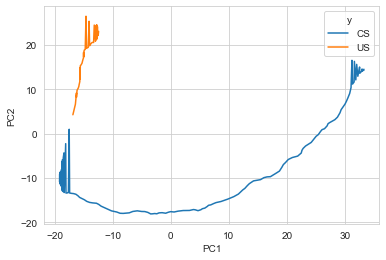

In [168]:
X = df

y = np.where(X.index <= 0, "CS", "US")
pipe = make_pipeline(PCA(2), LogisticRegression())
obs = cross_val_score(clone(pipe), X, y, scoring="f1_macro")

obs
plot_pcs(X, y)

In [164]:
# 1: Calculate Average Trace, Decompose, Classif
# 
# y
df

<function observational_fear.load.load_traces(data_dir: pathlib.Path, session: str) -> pandas.core.frame.DataFrame>

In [124]:
# 2: Align and decompose each trial, classify


In [ ]:
# 3: Decompose, de

In [144]:

X = df_real.dropna()
y = np.where(df_shuffled.index <= 0, "ITI", "CS")

pipe = make_pipeline(
    PCA(2), 
    LogisticRegression()
    )
real_scores = cross_val_score(pipe, X=X, y=y, scoring="f1_macro")
real_scores

array([0.85176471, 1.        , 1.        , 1.        , 0.8989899 ])

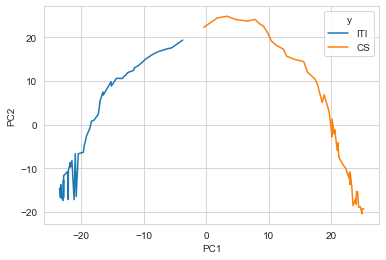

In [145]:
to_plot = pd.DataFrame(PCA(10).fit_transform(X)[:, :2], columns=["PC1", "PC2"]).assign(color=X.index)
to_plot["y"] = y
sns.lineplot(x="PC1", y="PC2", hue="y", data=to_plot, ci=None)
plt.savefig("CS classification tradjectory.svg")

In [116]:
X = df_shuffled.dropna()
y = np.where(df_shuffled.index <= 0, "ITI", "CS")

pipe = make_pipeline(PCA(2), LogisticRegression())
cross_val_score(pipe, X=X, y=y, scoring="f1_macro")

<Figure size 432x288 with 0 Axes>

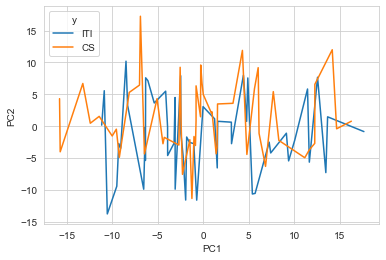

In [117]:
import seaborn as sns

to_plot = pd.DataFrame(PCA(10).fit_transform(X)[:, :2], columns=["PC1", "PC2"]).assign(color=X.index)
to_plot["y"] = y
sns.lineplot(x="PC1", y="PC2", hue="y", data=to_plot, ci=None)
plt.savefig("Shuffled classification tradjectory.svg")

In [120]:
shuffled_scores = []
for i in range(10):
    df_shuffled = df.sample(frac=1).copy()
    df_shuffled.index = df.index
    df_shuffled = prep_data(df_shuffled, cs_starts)
    X = df_shuffled.dropna()
    y = np.where(df_shuffled.index <= 0, "ITI", "CS")

    pipe = make_pipeline(PCA(2), LogisticRegression())
    scores=cross_val_score(pipe, X=X, y=y, scoring="f1_macro")
    shuffled_scores.append(scores)

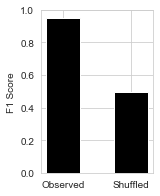

In [143]:
reps = np.array([x.mean() for x in shuffled_scores])
obs = real_scores.mean()
(reps > obs).mean()
plt.figure(figsize=(2, 3))
plt.bar(["Observed", "Shuffled"], [obs, reps.mean()], color="black", width=0.5)
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.savefig("CS Decoding result.svg")

In [133]:
reps

array([0.46514939, 0.39325829, 0.44477444, 0.58553984, 0.60662157,
       0.4402997 , 0.58437748, 0.52039717, 0.42254895, 0.46384218])

In [27]:
from sklearn.decomposition import PCA

mod = PCA().fit(dfp)
num_pcs = np.sum(np.cumsum(mod.explained_variance_ratio_) <= 0.9)

X = PCA(num_pcs).fit_transform(dfp)


In [121]:
X

new_id,0,1,10,1000,1003,1004,1005,1006,1008,1009,...,974,977,979,984,986,988,989,994,997,999
aligned,,,,,,,,,,,,,,,,,,,,,
-5.0,-0.178139,0.170349,-0.591137,-0.544893,0.529204,2.693560,-2.120775,1.329219,2.009390,-0.702436,...,-0.600328,-0.007527,-1.161548,-0.950762,0.300943,0.168930,-0.845285,0.676029,0.341195,-0.224920
-4.9,1.163870,-0.458473,-0.822439,-1.200632,1.394031,0.314084,-0.837723,-0.518350,0.389389,0.314209,...,-0.678232,-0.729403,1.125281,-0.692614,-1.127705,1.880388,-0.777029,-0.188237,-0.214337,1.313716
-4.8,0.137410,-1.046497,0.515403,-0.683387,1.862329,0.992400,1.107891,-0.631396,-0.428604,0.782432,...,0.894310,2.384938,0.458855,1.133605,0.182520,2.293653,-0.930173,0.715744,-0.928672,-1.451983
-4.7,0.463954,0.207772,-0.579294,0.189018,-0.724749,0.312096,-1.026221,-0.888692,-0.290072,0.997017,...,0.074085,0.250130,-1.613901,0.362859,-0.051531,-0.406634,-0.824211,1.024782,-0.280564,-0.166983
-4.6,-0.462287,2.194010,-0.717469,-0.952682,0.277348,0.882356,-0.956396,-1.821839,-0.519654,0.545195,...,-1.426545,0.373563,-0.946585,1.042694,1.502690,0.107091,1.004947,-0.383949,-0.479272,-2.559717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.6,-0.771945,0.044722,0.501349,0.962280,4.594505,-0.668383,-1.065671,0.078960,0.196624,0.387198,...,0.343720,0.595483,-0.864167,-0.881111,-0.307583,0.453130,0.448535,-0.551271,-0.471718,-1.202468
4.7,1.610018,-0.184567,-0.572105,-0.481983,1.652591,0.007242,-1.047311,-1.797787,2.607285,-0.471469,...,-0.157427,-1.343177,-1.022112,0.079090,1.366309,-0.807837,-0.852551,-0.325437,0.881803,-0.899963
4.8,0.258089,-0.552794,-0.754070,-0.422865,0.636762,-0.358177,-0.599809,1.631993,0.564394,-0.612552,...,-1.172688,-1.471752,-0.334379,-1.905919,-0.063806,-0.910895,-0.706101,-0.001497,0.641102,1.996807


In [17]:
np.sum(np.cumsum(mod.explained_variance_ratio_) <= 0.9)

13